В этом примере показано, как можно использовать **KBinsDiscretizer** векторное квантование для набора игрушечных изображений мордочки енота.

In [35]:
try:  # Scipy >= 1.10
    from scipy.datasets import face
except ImportError:
    from scipy.misc import face

# **Исходное изображение**

Начнем с загрузки изображения лица енота из **SciPy**. Мы дополнительно проверим пару сведений об изображении, таких как форма и тип данных, используемых для хранения изображения.

Обратите внимание, что в зависимости от версии **SciPy** мы должны адаптировать импорт, поскольку функция, возвращающая изображение, находится в другом модуле. **pooch** Кроме того, **SciPy >= 1.10** требует установки пакета .

In [36]:
raccoon_face = face(gray=True)

In [48]:
print(f"Размер изображения {raccoon_face.shape}")
print(f"Данные, используемые для кодирования изображения, имеют тип {raccoon_face.dtype}")
print(f"Количество байтов, занимаемых в оперативной памяти, равно {raccoon_face.nbytes}")

Размер изображения (768, 1024)
Данные, используемые для кодирования изображения, имеют тип uint8
Количество байтов, занимаемых в оперативной памяти, равно 786432


Таким образом, изображение представляет собой двумерный массив высотой 768 пикселей и шириной 1024 пикселя. Каждое значение представляет собой 8-битное целое число без знака, что означает, что изображение кодируется с использованием 8 бит на пиксель. Общее использование памяти изображения составляет 786 килобайт (1 байт равен 8 битам).

Использование 8-битного целого числа без знака означает, что изображение закодировано с использованием максимум 256 различных оттенков серого. Мы можем проверить распределение этих значений.

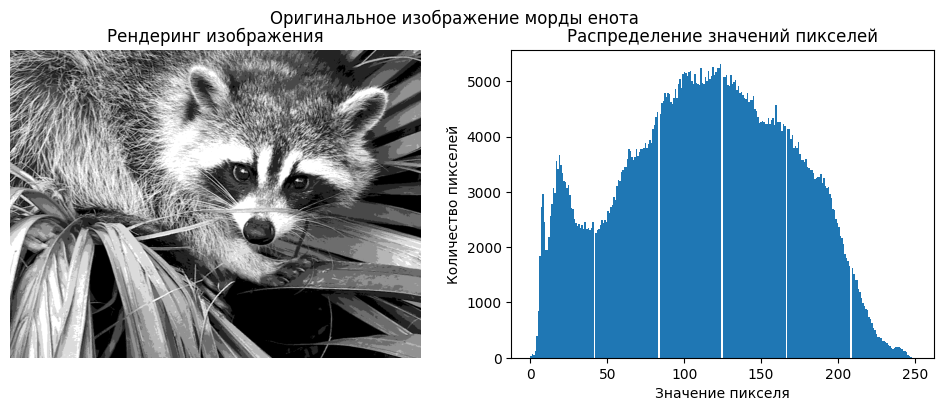

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].imshow(compressed_raccoon_kmeans, cmap=plt.cm.gray)
ax[0].axis("off")
ax[0].set_title("Рендеринг изображения")
ax[1].hist(raccoon_face.ravel(), bins=256)
ax[1].set_xlabel("Значение пикселя")
ax[1].set_ylabel("Количество пикселей")
ax[1].set_title("Распределение значений пикселей")
_ = fig.suptitle("Оригинальное изображение морды енота")

# **Сжатие посредством векторного квантования**

Идея сжатия с помощью векторного квантования состоит в том, чтобы уменьшить количество уровней серого для представления изображения. Например, мы можем использовать 8 значений вместо 256 значений. Следовательно, это означает, что мы можем эффективно использовать 3 бита вместо 8 бит для кодирования одного пикселя и, следовательно, уменьшить использование памяти примерно в 2,5 раза. 

# **Стратегия кодирования**

Сжатие может быть выполнено с помощью файла KBinsDiscretizer. Нам нужно выбрать стратегию для определения 8 значений серого для подвыборки. Простейшая стратегия состоит в том, чтобы определить их на равном расстоянии друг от друга, что соответствует установке strategy="uniform". Из предыдущей гистограммы мы знаем, что эта стратегия, безусловно, не оптимальна.

In [68]:
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 8
encoder = KBinsDiscretizer(
    n_bins=n_bins, encode="ordinal", strategy="uniform", random_state=0
)
compressed_raccoon_uniform = encoder.fit_transform(raccoon_face.reshape(-1, 1)).reshape(
    raccoon_face.shape
)

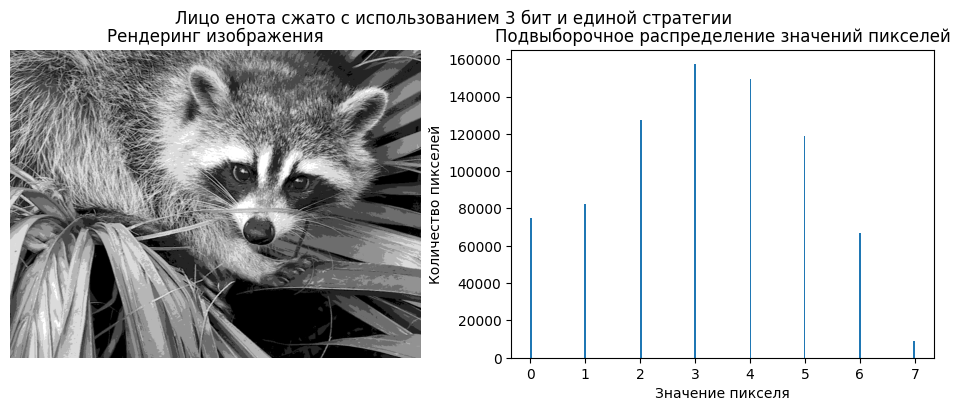

In [69]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].imshow(compressed_raccoon_uniform, cmap=plt.cm.gray)
ax[0].axis("off")
ax[0].set_title("Рендеринг изображения")
ax[1].hist(compressed_raccoon_uniform.ravel(), bins=256)
ax[1].set_xlabel("Значение пикселя")
ax[1].set_ylabel("Количество пикселей")
ax[1].set_title("Подвыборочное распределение значений пикселей")
_ = fig.suptitle("Лицо енота сжато с использованием 3 бит и единой стратегии")

Качественно мы можем выделить несколько небольших областей, где мы видим эффект сжатия (например, листья в правом нижнем углу). Но в конце концов, полученное изображение все еще выглядит хорошо.

Мы видим, что распределение значений пикселей было сопоставлено с 8 различными значениями. Мы можем проверить соответствие между такими значениями и исходными значениями пикселей.

In [70]:
bin_edges = encoder.bin_edges_[0]
bin_center = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2
bin_center

array([ 15.625,  46.875,  78.125, 109.375, 140.625, 171.875, 203.125,
       234.375])

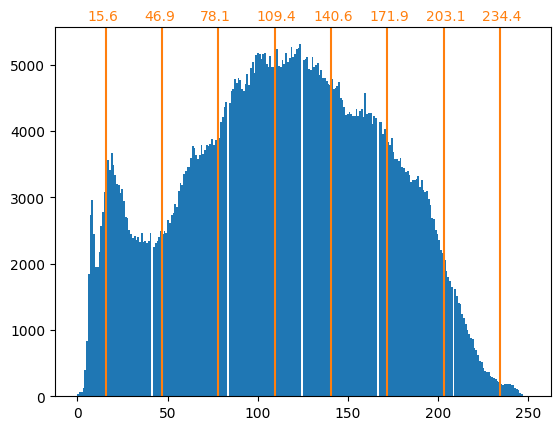

In [71]:
_, ax = plt.subplots()
ax.hist(raccoon_face.ravel(), bins=256)
color = "tab:orange"
for center in bin_center:
    ax.axvline(center, color=color)
    ax.text(center - 10, ax.get_ybound()[1] + 100, f"{center:.1f}", color=color)

Как указывалось ранее, стратегия однородной выборки не оптимальна. Обратите внимание, например, что пиксели, сопоставленные со значением 7, будут кодировать довольно небольшое количество информации, тогда как сопоставленное значение 3 будет представлять большое количество отсчетов. Вместо этого мы можем использовать стратегию кластеризации, такую ​​как k-means, чтобы найти более оптимальное отображение.

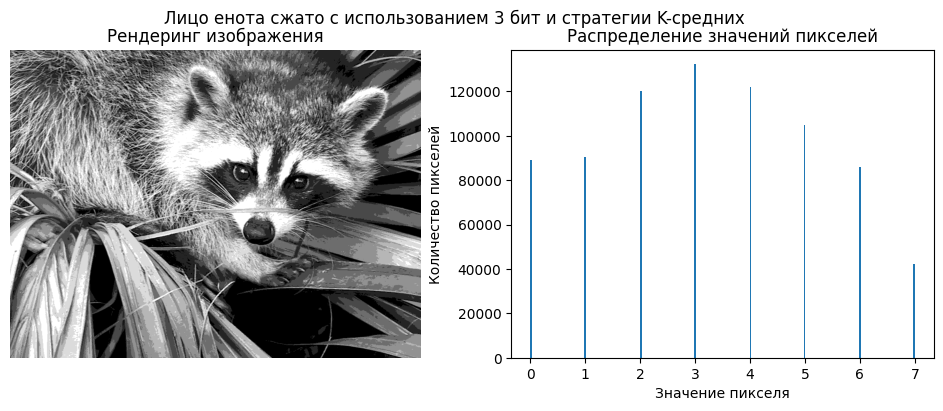

In [72]:
encoder = KBinsDiscretizer(
    n_bins=n_bins, encode="ordinal", strategy="kmeans", random_state=0
)
compressed_raccoon_kmeans = encoder.fit_transform(raccoon_face.reshape(-1, 1)).reshape(
    raccoon_face.shape
)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].imshow(compressed_raccoon_kmeans, cmap=plt.cm.gray)
ax[0].axis("off")
ax[0].set_title("Рендеринг изображения")
ax[1].hist(compressed_raccoon_kmeans.ravel(), bins=256)
ax[1].set_xlabel("Значение пикселя")
ax[1].set_ylabel("Количество пикселей")
ax[1].set_title("Распределение значений пикселей")
_ = fig.suptitle("Лицо енота сжато с использованием 3 бит и стратегии K-средних")

In [73]:
bin_edges = encoder.bin_edges_[0]
bin_center = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2
bin_center

array([ 18.9141241 ,  53.3627656 ,  82.65000752, 109.26055499,
       134.68738405, 159.79431128, 185.18557327, 224.01945707])

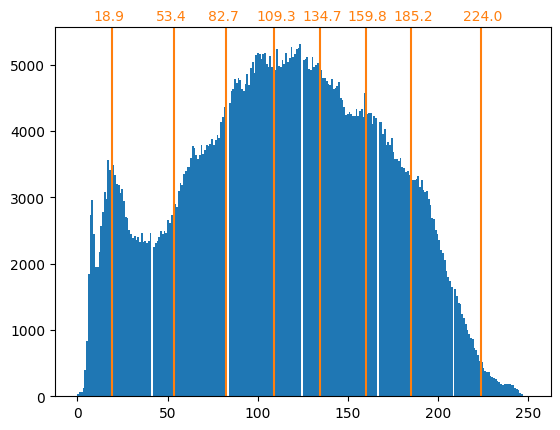

In [74]:
_, ax = plt.subplots()
ax.hist(raccoon_face.ravel(), bins=256)
color = "tab:orange"
for center in bin_center:
    ax.axvline(center, color=color)
    ax.text(center - 10, ax.get_ybound()[1] + 100, f"{center:.1f}", color=color)

Счетчики в ячейках теперь более сбалансированы, а их центры больше не расположены на одинаковом расстоянии друг от друга. Обратите внимание, что мы могли бы обеспечить одинаковое количество пикселей на бин, используя strategy="quantile"вместо strategy="kmeans".

# **Объем памяти**

Ранее мы заявляли, что должны экономить в 8 раз меньше памяти. Давайте проверим это.

In [75]:
print(f"Количество байтов, занимаемых в оперативной памяти, равно {compressed_raccoon_kmeans.nbytes}")
print(f"Коэффициент сжатия: {compressed_raccoon_kmeans.nbytes / raccoon_face.nbytes}")

Количество байтов, занимаемых в оперативной памяти, равно 6291456
Коэффициент сжатия: 8.0


Довольно удивительно видеть, что наше сжатое изображение занимает в восемь раз больше памяти, чем исходное изображение. Это действительно противоположно тому, что мы ожидали. Причина в основном связана с типом данных, используемых для кодирования изображения.

In [76]:
print(f"Тип сжатого изображения: {compressed_raccoon_kmeans.dtype}")

Тип сжатого изображения: float64


Действительно, на выходе KBinsDiscretizer получается массив 64-битных чисел с плавающей запятой. Это означает, что он занимает в 8 раз больше памяти. Однако мы используем это 64-битное представление с плавающей запятой для кодирования 8 значений. Действительно, мы сэкономим память, только если приведем сжатое изображение к массиву 3-битных целых чисел. Мы могли бы использовать метод numpy.ndarray.astype. Однако 3-битного целочисленного представления не существует, и для кодирования 8 значений нам также потребуется использовать 8-битное целочисленное представление без знака.

На практике для наблюдения за увеличением объема памяти исходное изображение должно быть представлено в 64-битном представлении с плавающей запятой.